Setup

In [1]:
import numpy as np
from keras import layers
import keras
import matplotlib.pyplot as plt

2026-02-04 12:10:38.174636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770207038.377523      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770207038.434994      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
DATASET_PATH = r"/kaggle/input/pizzas-dataset/labeled_dataset"
MODELS_PATH = r"/kaggle/working/models"

train_data_dir = os.path.join(DATASET_PATH, 'train')
validation_data_dir = os.path.join(DATASET_PATH, 'val')
test_data_dir = os.path.join(DATASET_PATH, 'test')

name_modelH5 = os.path.join(MODELS_PATH, "my_model.h5")
name_model_keras = os.path.join(MODELS_PATH, "my_model.keras")
name_modelTFLite = os.path.join(MODELS_PATH, "my_model.tflite")

In [4]:
from tensorflow.keras.preprocessing import  image_dataset_from_directory

image_size = (224, 224)
batch_size = 32

train_ds = image_dataset_from_directory(
    train_data_dir,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = image_dataset_from_directory(
    test_data_dir,
    shuffle = False, #shuffle set to false in order to compute the confusion matrix later
    image_size=image_size,
    batch_size=batch_size,
)

validation_ds = image_dataset_from_directory(
    validation_data_dir,
    image_size=image_size,
    batch_size=batch_size,
)

Found 14400 files belonging to 4 classes.


I0000 00:00:1770207075.139873      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1800 files belonging to 4 classes.
Found 1800 files belonging to 4 classes.


In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet import EfficientNetB0

inputs = layers.Input(shape=(224, 224, 3))

base_model = EfficientNetB0(
    include_top=False,
    weights=None,      
    pooling=None,
    input_shape=(224, 224, 3)
)

base_model.load_weights('/kaggle/input/efficientnetb0-weights/keras/default/1/efficientnetb0_notop.h5')
base_model.trainable = False

x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetb0 (Functional)         │ (None, 7, 7, 1280)           │     4,049,571 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization                 │ (None, 1280)                 │         5,120 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 256)                  │       327,936 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_1 (Dropout)                 │ (None, 256)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_1 (Dense)                     │ (None, 4)                    │         1,028 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [6]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2


I0000 00:00:1770207119.566121     106 service.cc:148] XLA service 0x7d5bc814f510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770207119.566881     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770207121.910786     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/450 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.3607 - loss: 1.9435 

I0000 00:00:1770207133.109948     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.8690 - loss: 0.3908 - val_accuracy: 0.9794 - val_loss: 0.0628
Epoch 2/2
450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9589 - loss: 0.1339 - val_accuracy: 0.9894 - val_loss: 0.0344


In [7]:
model.save(name_modelH5)
keras.saving.save_model(model, name_model_keras)

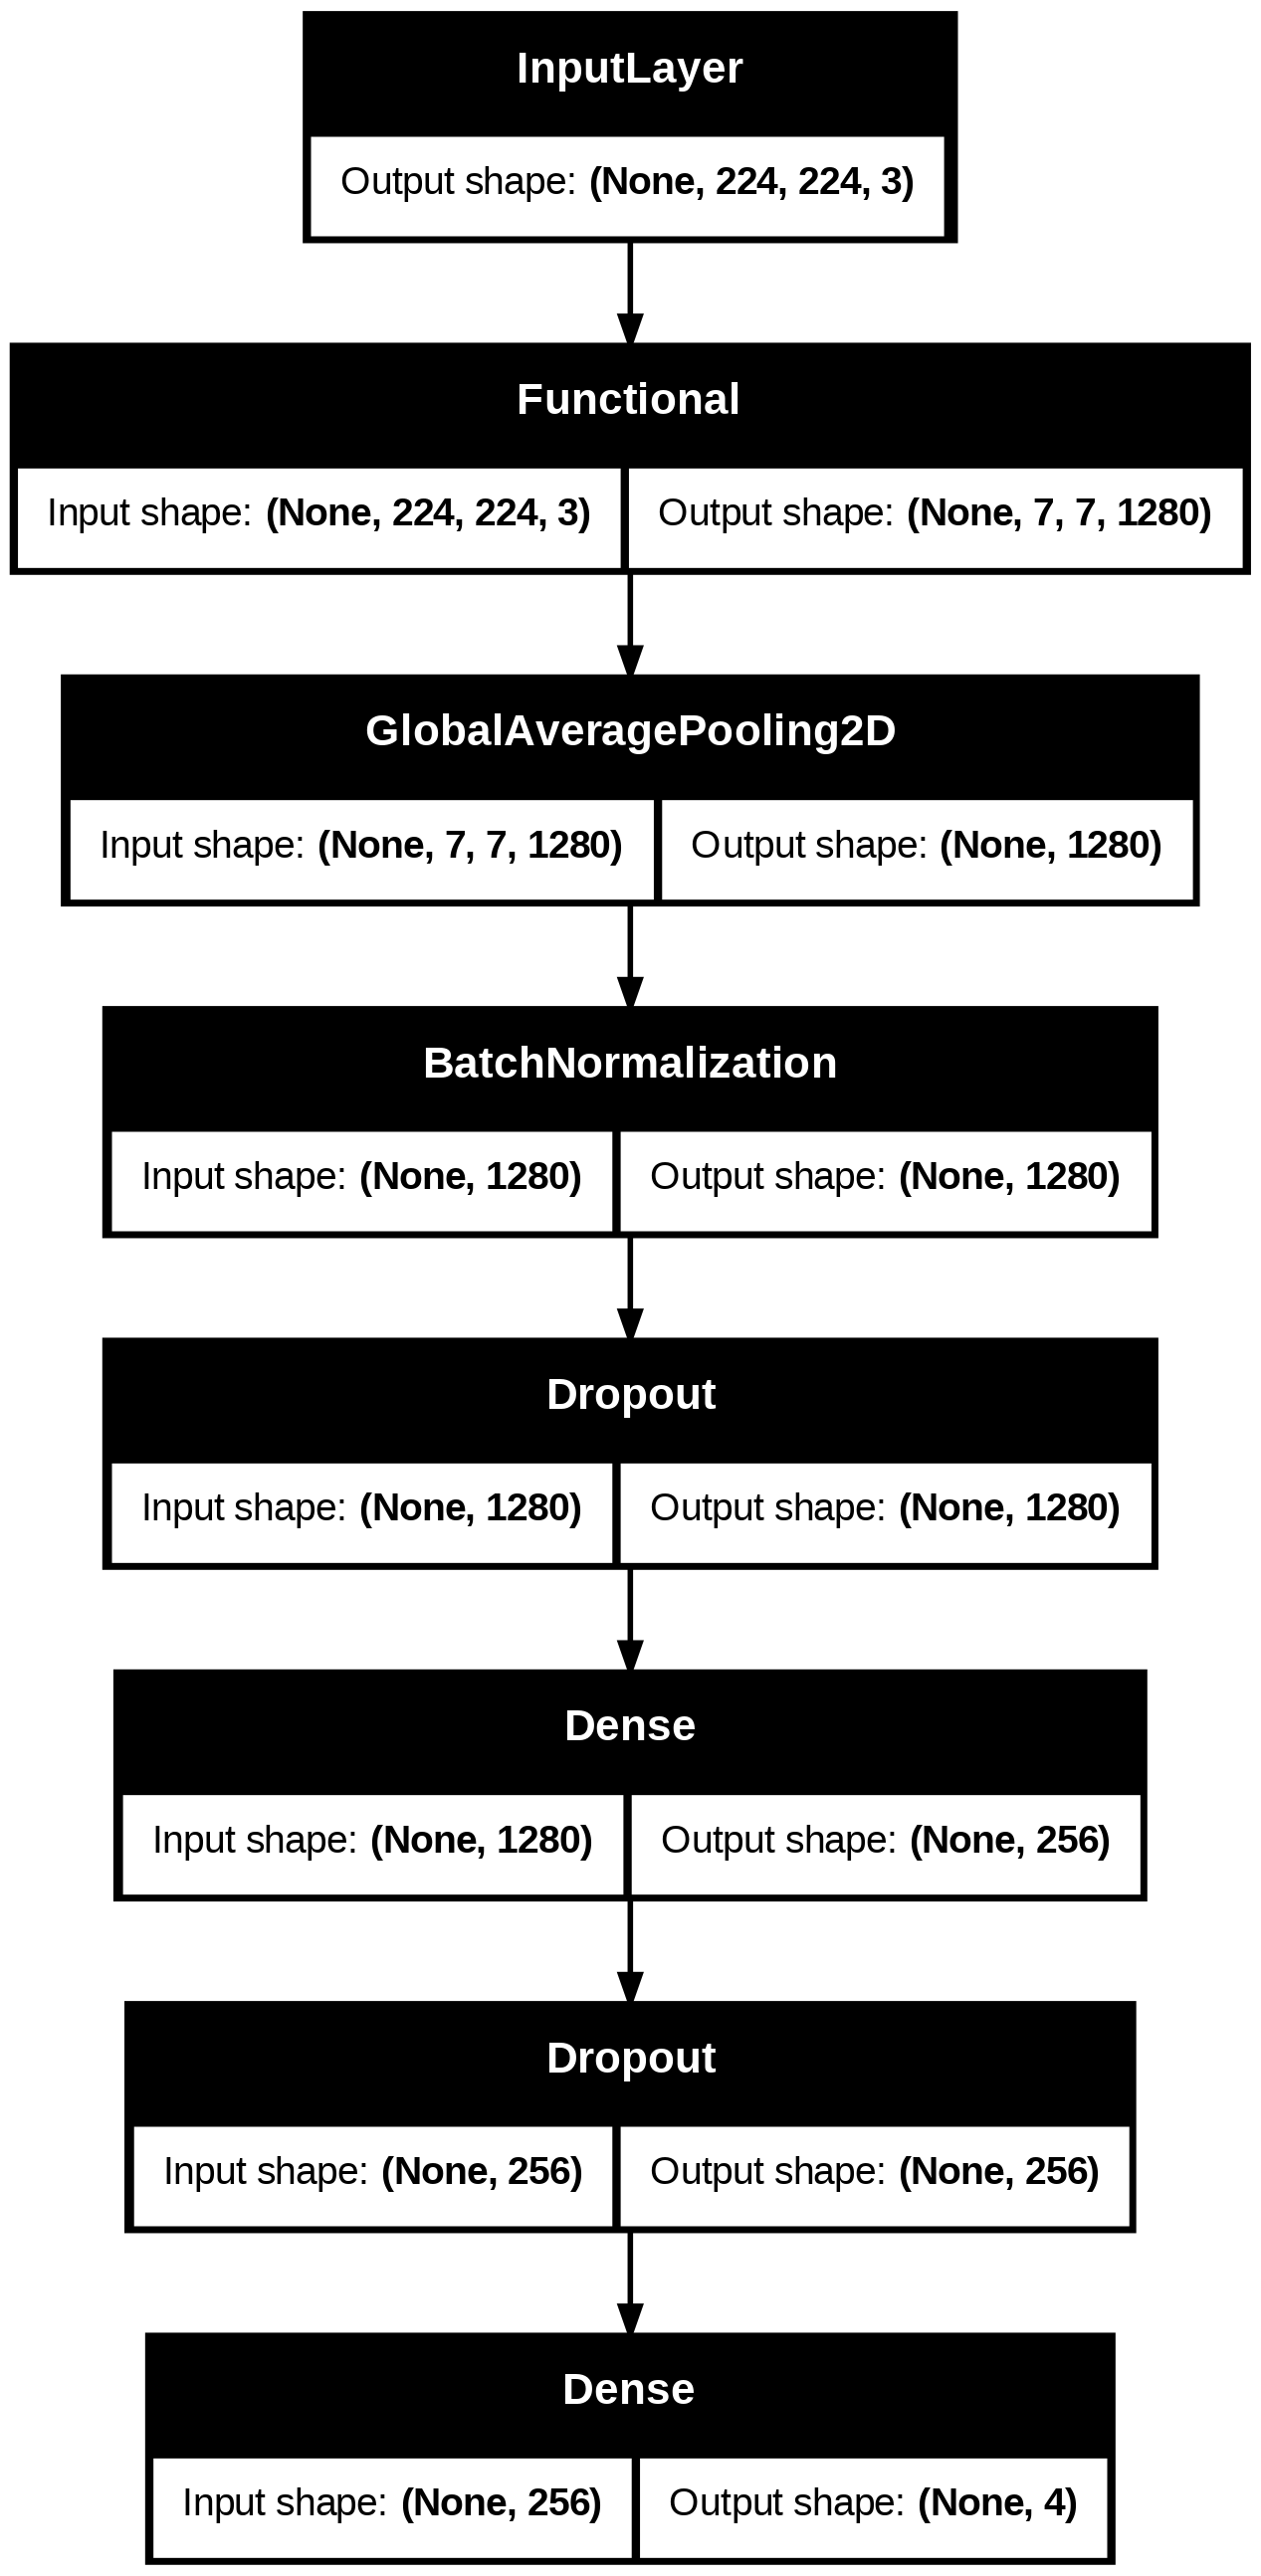

In [8]:
keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

Test dataset evaluation:
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9815 - loss: 0.0560
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step
Confusion Matrix:


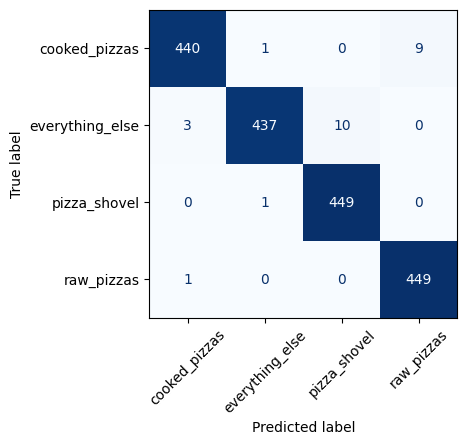

In [9]:
print("Test dataset evaluation:")
model.evaluate(test_ds)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_names = train_ds.class_names
n_classes = len(class_names)

all_data = test_ds.unbatch().batch(1800)
X_test, y_true = next(iter(all_data))

y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.xticks(rotation=45)

print("Confusion Matrix:")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


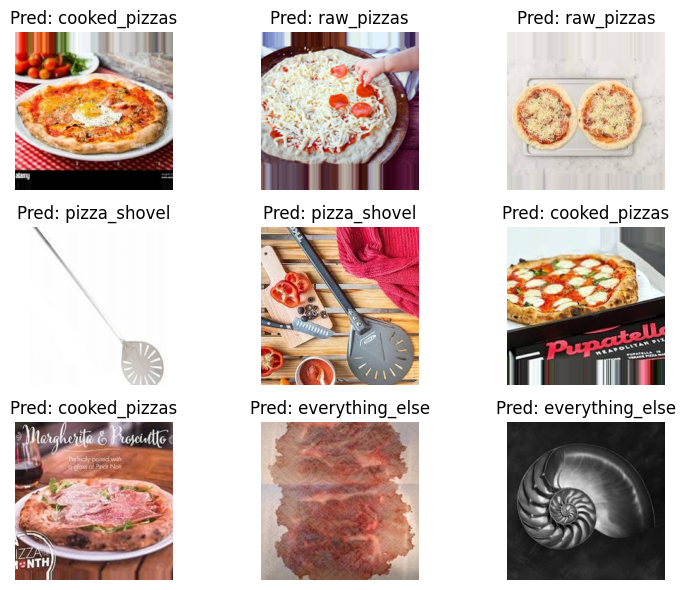

In [19]:
import matplotlib.pyplot as plt
import numpy as np

class_names = train_ds.class_names 
sample = test_ds.unbatch().shuffle(1800).take(9)


imgs = np.stack([img.numpy().astype("uint8") for img, _ in sample])
lbls = np.array([lbl.numpy() for _, lbl in sample])
preds = model.predict(imgs)

fig, axs = plt.subplots(3, 3, figsize=(8, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(imgs[i])
    ax.set_title(f"Pred: {class_names[np.argmax(preds[i])]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [20]:
from tensorflow.keras.preprocessing import  image_dataset_from_directory

img_width, img_height = (224, 224)

input_ds = image_dataset_from_directory(train_data_dir,
                                        shuffle=True,
                                        batch_size=1,
                                        image_size=(img_width, img_height),
                                        label_mode=None)


def representative_dataset_gen():
	for input_value in input_ds.take(100):
		yield [input_value]

Found 14400 files.


In [ ]:
import tensorflow as tf

#takes keras model and turn it in a converter TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.representative_dataset = representative_dataset_gen 

#quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#conversion to int16
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.target_spec.supported_types = [tf.int16]
#do not quantize in & out

tflite_quant_model = converter.convert()

open(name_modelTFLite, "wb").write(tflite_quant_model)

print('Quantization done.')

In [28]:
import numpy as np
import tensorflow as tf

def matrix_confusion(original_labels, predictions, n_class, nb_test_samples):
    # initialize a zero matrix sized by the number of classes
    confusion_matrix = np.zeros((n_class, n_class))

    # compare true labels vs. predicted labels
    if len(original_labels.shape) > 1 and original_labels.shape[1] > 1:
        original_labels = np.argmax(original_labels, axis=1)

    l = len(original_labels)
    for k in range(l):
        confusion_matrix[int(original_labels[k])][int(predictions[k])] += 1

    print('confusion matrix:\n', confusion_matrix)
    print('\n')

    # compute prediction accuracy
    correct_predictions = sum(confusion_matrix[i][i] for i in range(n_class))
    accuracy = correct_predictions / nb_test_samples
    print('ACCURACY... : ', round(accuracy * 100, 2), '%')
    print('\n')

    return confusion_matrix


def vectors_from_dataset(dataset):
    x = []
    y = []
    for batch_images, batch_labels in dataset:
        x.append(batch_images.numpy())
        y.append(batch_labels.numpy())

    x = np.concatenate(x, axis=0)
    y = np.concatenate(y, axis=0)
    
    if y.ndim > 1:
        y = np.argmax(y, axis=1)
        
    return x, y


def tflite_model_test(model_path, x_test, y_test, num_classes):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details  = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_type     = input_details[0]['dtype']
    input_scale, input_zero_point = input_details[0]['quantization']

    predictions = []
    for x in x_test:
        input_tensor = np.expand_dims(x, axis=0)
        
        if input_type in [np.uint8, np.int8] and input_scale > 0:
            input_tensor = (input_tensor / input_scale + input_zero_point).astype(input_type)
        
        if x.dtype != input_type:
            input_tensor = input_tensor.astype(input_type)

        interpreter.set_tensor(input_details[0]['index'], input_tensor)
        interpreter.invoke()
        tflite_results = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(np.argmax(tflite_results))

    nb_test_samples = x_test.shape[0]
    matrix = matrix_confusion(y_test, predictions, num_classes, nb_test_samples)
    return matrix

(x_test, y_test) = vectors_from_dataset(test_ds)
print("Metrics:")
_ = tflite_model_test("/kaggle/working/models/my_model.tflite", x_test, y_test, 4)

Metrics:
confusion matrix:
 [[440.   1.   0.   9.]
 [  3. 437.  10.   0.]
 [  0.   1. 449.   0.]
 [  1.   0.   0. 449.]]


ACCURACY... :  98.61 %


